In [38]:
import pandas as pd
pd.set_option('display.max_columns', 55)
import random
import numpy as np

from pathlib import Path

%matplotlib inline

In [39]:
DATA_DIR = Path("/mnt/data2/cars/")

# Read dataset

In [40]:
def read_year(year):
    print(year)
    filename = DATA_DIR / "VehicleEmissions{}_CABQ-en-us.csv".format(year)
    if year == 2016 or year == 2017:
        return pd.read_csv(filename, sep=",", dtype=str)    
    else:
        return pd.read_csv(filename, encoding="utf-16", dtype=str, sep="\t")

cars = [read_year(year) for year in range(2004, 2019)]

2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017
2018


In [41]:
columns = cars[0].columns
for df in cars:
    assert list(df.columns) == list(columns)

In [42]:
cars = pd.concat(cars)
cars = cars.reset_index(drop=True)

In [43]:
len(cars)

4091788

In [44]:
# remove whitespace
for col in cars.columns:
    cars[col] = cars[col].str.strip()

In [45]:
# Parse dates, this will unify the different date formats used in the dataset
time_columns = ["TEST_SDATE", "TEST_EDATE"]
for col in time_columns:
    cars[col] = pd.to_datetime(cars[col])

# Get statistics before cleanup

In [49]:
print("Number of rows", len(cars))
print("Number of columns", len(cars.columns))
print("Number of cars", cars["VIN"].nunique())
results = cars["OVERALL_RESULT"].value_counts()
print("%fail", results.loc["F"] / (results.loc["P"]+results.loc["F"]))

Number of rows 4091788
Number of columns 127
Number of cars 1337877
%fail 0.11371456420690297


# Remove invalid rows

### Invalid VIN

In [50]:
incorrect_vin_length = cars["VIN"].str.len() != 17
vin_all_zeros = cars["VIN"] == "00000000000000000"
print("Number of rows with incorrect length VIN: {}".format(incorrect_vin_length.sum()))
print("Number of rows with all-zero VIN: {}".format(vin_all_zeros.sum()))

cars = cars[(~incorrect_vin_length) & (~vin_all_zeros)]

Number of rows with incorrect length VIN: 108846
Number of rows with all-zero VIN: 32


### Training inspectors

The dataset also contains records for inspections that were done to train new inspectors. These do not hold any
value for our models and should be removed. Only some inspections are clearly marked, for others need to notice weird
inspection patterns. I found the following markers of training inspections

* TEST_TYPE = T
* MECHANIC_LAST_NAME=PRACTICE
* many inspections on the same date

To be safe, completely remove any cars that ever were involved with a training

#### Explicitly marked as training

In [51]:
training = cars["TEST_TYPE"] == "T"
bad_vins = cars[training]["VIN"].unique()

print("Number of cars explicitly marked as training: {}".format(len(bad_vins)))
cars = cars[~cars["VIN"].isin(bad_vins)]

Number of cars explicitly marked as training: 872


#### Inspector name is "practice" or "PRACTICE"

In [52]:
training = (cars["MECHANIC_LAST_NAME"].str.lower() == "practice") &  (cars["MECHANIC_FIRST_NAME"].str.lower() == "test")
bad_vins = cars[training]["VIN"].unique()

print("Number of cars implicitly marked as training: {}".format(len(bad_vins)))
cars = cars[~cars["VIN"].isin(bad_vins)]

Number of cars implicitly marked as training: 11369


#### Many tests per day

In [53]:
# some cars have had a *lot* of tests
cars["VIN"].value_counts().head()

1FTPX14585NA67218    86
1GCDC14H0CF378531    74
5TBBT44172S257014    41
1FMPU18L3YLC29124    41
1HGCR2F3XDA126951    41
Name: VIN, dtype: int64

In [54]:
# typcially a huge number of tests happen on the same day
cars[cars["VIN"] == "1FTPX14585NA67218"]["TEST_SDATE"].dt.date.value_counts()

2016-02-05    60
2016-02-08    21
2010-06-02     1
2014-11-07     1
2016-12-15     1
2008-06-16     1
2012-10-04     1
Name: TEST_SDATE, dtype: int64

In [55]:
# zooming in see many consecutive tests that all are "pass" - not a normal pattern
cars[cars["VIN"] == "1FTPX14585NA67218"][["TEST_SDATE", "INSPECTOR_NUM", "OVERALL_RESULT"]].head(10)

,TEST_SDATE,INSPECTOR_NUM,OVERALL_RESULT
1246060,2008-06-16 11:11:00,1809071,P
1809834,2010-06-02 07:24:00,1809071,P
2397724,2012-10-04 14:24:00,AC084153,P
2746854,2014-11-07 11:22:00,AC084272,P
3299297,2016-02-05 09:14:21,EHVPMLWP,P
3299298,2016-02-05 09:23:00,EHVPMLWP,P
3299299,2016-02-05 09:28:06,EHVPMLWP,P
3299300,2016-02-05 09:32:26,EHVPMLWP,P
3299301,2016-02-05 09:37:03,EHVPMLWP,P
3299302,2016-02-05 09:40:48,EHVPMLWP,P


In [56]:
# having more than 3 tests per day is very unlikely
cars["TEST_SDATE_DAY"] = cars["TEST_SDATE"].dt.date
num_tests_per_day = cars.groupby(["VIN", "TEST_SDATE_DAY"]).size()
del cars["TEST_SDATE_DAY"]
num_tests_per_day.value_counts()

1     3449808
2      193246
3       16697
4        3190
5         587
6         194
7          53
8          22
9          11
10          4
12          2
11          2
60          1
21          1
dtype: int64

In [57]:
# -> remove any car that at least once was tested more than three times per day
too_many_tests = num_tests_per_day[num_tests_per_day > 3] 
bad_vins = set(too_many_tests.reset_index()["VIN"].unique())
print("number of cars that experience weird testing patterns: {}".format(len(bad_vins)))

cars = cars[~cars["VIN"].isin(bad_vins)]

number of cars that experience weird testing patterns: 3986


### Weird INSPECTOR_NUM

In [58]:
# in earlier years, most INSPECTOR_NUM are numeric
numeric = cars["INSPECTOR_NUM"].str.match("[0-9]{5,8}").fillna(False)
num_numeric = cars[numeric]["INSPECTOR_NUM"].nunique()
print("Inspectors whose INSPECTOR_NUM contains only numbers: {}".format(num_numeric))

Inspectors whose INSPECTOR_NUM contains only numbers: 1139


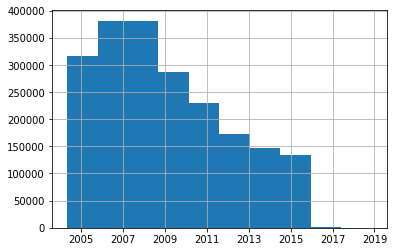

In [59]:
cars[numeric]["TEST_SDATE"].hist()

In [60]:
# in later years, INSPECTOR_NUM often starts with an A followed by numbers and letters
alphanumeric =  cars["INSPECTOR_NUM"].str.match("A[A-Z0-9]{5,7}").fillna(False)
num_alphanumeric = cars[alphanumeric]["INSPECTOR_NUM"].nunique()
print("Inspectors whose INSPECTOR_NUM is alphanumeric: {}".format(num_alphanumeric))

Inspectors whose INSPECTOR_NUM is alphanumeric: 1625


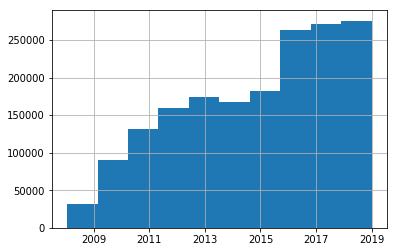

In [61]:
cars[alphanumeric]["TEST_SDATE"].hist()

In [62]:
# sometimes inspector num starts with EHVP
# have observed that many training rows have an EHVP inspector num
ehvp = cars["INSPECTOR_NUM"].str.startswith("EHVP")
num_ehvp = cars[ehvp]["INSPECTOR_NUM"].nunique()
print("Inspectors whose INSPECTOR_NUM starts with EHVP: {}".format(num_ehvp))

Inspectors whose INSPECTOR_NUM starts with EHVP: 16


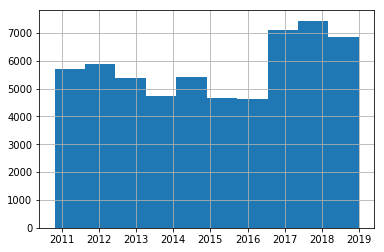

In [63]:
cars[ehvp]["TEST_SDATE"].hist()

In [64]:
# and there are some random others
other = ~numeric & ~alphanumeric &~ehvp
num_other = cars[other]["INSPECTOR_NUM"].nunique()
print("Inspectors whose INSPECTOR_NUM follows other scheme: {}".format(num_other))

Inspectors whose INSPECTOR_NUM follows other scheme: 13


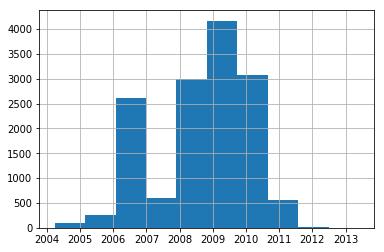

In [65]:
cars[other]["TEST_SDATE"].hist()

In [66]:
cars[other]["INSPECTOR_NUM"].value_counts()

Timothy    4750
PATRICK    3634
STEVEN     3148
VPDM012    1327
VPMD012     883
STEVE       253
5034        211
40           94
0            70
LUIS          6
9032          4
A0002         4
666HELL       1
Name: INSPECTOR_NUM, dtype: int64

In [67]:
cars[other]["VIN"].nunique()

12611

In [68]:
bad_vins = set(cars[other | ehvp]["VIN"].unique())
cars = cars[~cars["VIN"].isin(bad_vins)]

In [69]:
len(cars)

3526232

# Store cleaned dataset

In [70]:
cars.to_csv(DATA_DIR / "cleaned.csv", index=False) 

# Make a sample

In [71]:
np.random.seed(1234)

In [72]:
sample = cars.groupby("VIN").filter(lambda x: np.random.uniform() < 0.1)

In [73]:
sample.to_csv(DATA_DIR / "sample.csv", index=False)

# Get statistics after cleanup

In [76]:
print("Number of rows", len(cars))
print("Number of columns", len(cars.columns))
print("Number of cars", cars["VIN"].nunique())
results = cars["OVERALL_RESULT"].value_counts()
print("%fail", results.loc["F"] / (results.loc["P"]+results.loc["F"]))

Number of rows 3526232
Number of columns 127
Number of cars 1241697
%fail 0.08835335420993473


In [78]:
print("Number of rows", len(sample))
print("Number of columns", len(sample.columns))
print("Number of cars", sample["VIN"].nunique())
results = sample["OVERALL_RESULT"].value_counts()
print("%fail", results.loc["F"] / (results.loc["P"]+results.loc["F"]))

Number of rows 353364
Number of columns 127
Number of cars 124469
%fail 0.08806521799342035
